Import all Libraries

In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, f1_score, precision_score, recall_score)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.2.5


Load datasets and merge into one.

In [50]:
df_red = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Red.csv")
df_Rose = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Rose.csv")
df_sparkling = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/Sparkling.csv")
df_white = pd.read_csv("Data/Raw/Wine_Datasets/Kaggle/White.csv")

df = pd.concat([df_red, df_Rose, df_sparkling, df_white], ignore_index=True)

X = df.drop("Price", axis=1)
y = df["Price"]

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (13834, 8)

Columns: ['Name', 'Country', 'Region', 'Winery', 'Rating', 'NumberOfRatings', 'Price', 'Year']

First few rows:


,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


Now lets analyse the data and its spread before we apply SMOTE

Rating distribution summary (discrete):
Samples (non-null): 13834
Mean: 3.37
Median: 3.00
Std Dev: 0.49
Skewness: 0.492
Kurtosis: -1.636
IQR: 1.00 (Q1=3.00, Q3=4.00)
Outliers (outside 1.5*IQR): 0 (0.00%)


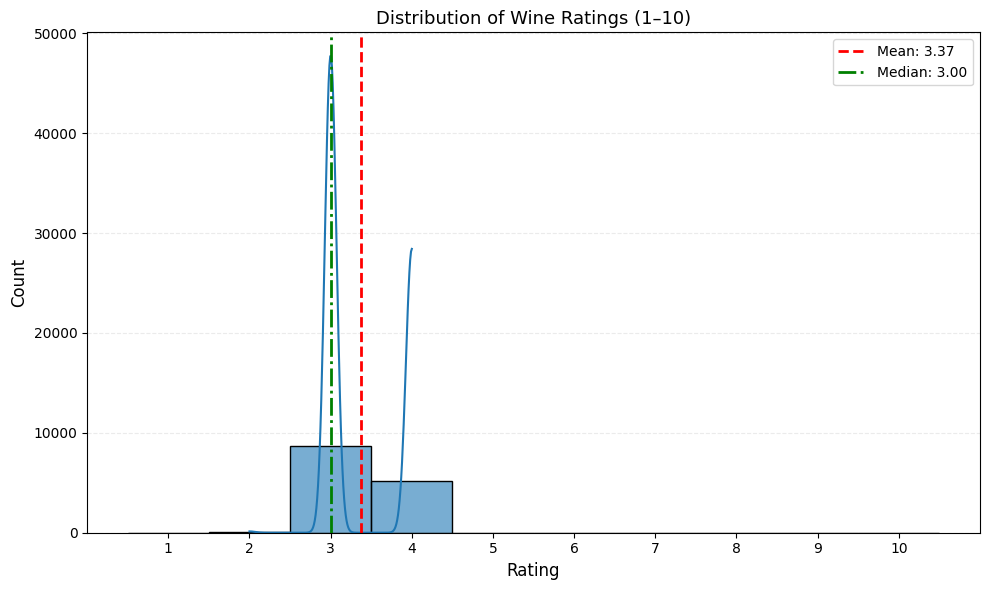

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure 'Rating' is available in X
rating = X['Rating'].dropna().astype(int)
n_samples = len(rating)

# Basic descriptive statistics
mean = rating.mean()
median = rating.median()
std = rating.std()
skew = rating.skew()
kurt = rating.kurt()
q1 = rating.quantile(0.25)
q3 = rating.quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr
n_outliers = rating[(rating < lower_fence) | (rating > upper_fence)].shape[0]

print("Rating distribution summary (discrete):")
print("="*60)
print(f"Samples (non-null): {n_samples}")
print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Std Dev: {std:.2f}")
print(f"Skewness: {skew:.3f}")
print(f"Kurtosis: {kurt:.3f}")
print(f"IQR: {iqr:.2f} (Q1={q1:.2f}, Q3={q3:.2f})")
print(f"Outliers (outside 1.5*IQR): {n_outliers} ({(n_outliers / n_samples * 100) if n_samples else 0:.2f}%)")
print("="*60)

# Plot histogram with KDE and mean/median lines
fig, ax = plt.subplots(figsize=(10, 6))
bins_used = np.arange(0.5, 10.5 + 1, 1)
sns.histplot(rating, bins=bins_used, kde=True, color='C0', edgecolor='black', alpha=0.6, ax=ax)
ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
ax.axvline(median, color='green', linestyle='-.', linewidth=2, label=f'Median: {median:.2f}')
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Wine Ratings (1–10)', fontsize=13)
ax.set_xticks(range(1, 11))
ax.legend()
ax.grid(axis='y', alpha=0.25, linestyle='--')

plt.tight_layout()
plt.show()


Train Test Split

In [54]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.30,  # 70/30 split
    random_state=42
)


Apply SMOTE to balance training Data

In [62]:
# --- SMOTE Balancing with All Ratings (1–10 enforced and valid for SMOTE) ---
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter
import numpy as np
import pandas as pd
import scipy.sparse as sp

# 1️⃣ Prepare data
rating_train = X_train['Rating'].astype(int)

X_proc = X_train.copy()
X_proc['Year_num'] = pd.to_numeric(
    X_proc['Year'].replace({'N.V.': np.nan}), errors='coerce'
)
X_proc['Year_num'].fillna(X_proc['Year_num'].median(), inplace=True)
X_proc = X_proc.drop(columns=['Rating'], errors='ignore')

# 2️⃣ Define preprocessing
numeric_features = ['NumberOfRatings', 'Year_num']
categorical_features = ['Country', 'Region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ],
    remainder='drop'
)

X_trans = preprocessor.fit_transform(X_proc)

# 3️⃣ Ensure all ratings (1–10) exist — add multiple seeds per missing rating
all_ratings = np.arange(1, 11)
existing = np.unique(rating_train)
missing = np.setdiff1d(all_ratings, existing)

if len(missing) > 0:
    print(f"⚠️ Missing ratings found: {missing}. Adding synthetic seeds...")
    rng = np.random.default_rng(42)
    n_seed_per_class = 6  # minimum needed for SMOTE with k_neighbors=5
    sample_indices = rng.choice(len(X_trans), size=len(missing) * n_seed_per_class)
    X_missing = X_trans[sample_indices]
    y_missing = np.repeat(missing, n_seed_per_class)

    # Combine with existing data
    X_trans = np.vstack([X_trans, X_missing])
    rating_train = np.concatenate([rating_train, y_missing])

print("Original (augmented) rating distribution:", Counter(rating_train))

# 4️⃣ Apply SMOTE (now all 1–10 exist with ≥6 samples)
sm = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res_rating = sm.fit_resample(X_trans, rating_train)

print("After SMOTE rating distribution:", Counter(y_res_rating))
print(f"Shapes -> before: {X_trans.shape}, after: {X_res.shape}")

# 5️⃣ Reattach continuous Price values
rng = np.random.default_rng(42)
rating_to_prices = {
    r: y_train[X_train['Rating'].astype(int) == r].values
    if len(y_train[X_train['Rating'].astype(int) == r]) > 0
    else y_train.values
    for r in all_ratings
}
y_res_price = np.array([rng.choice(rating_to_prices[int(r)]) for r in y_res_rating])

# 6️⃣ Rebuild DataFrame
num_names = numeric_features
ohe = preprocessor.named_transformers_['cat']
cat_names = [f"{categorical_features[i]}_{cat}"
             for i, cats in enumerate(ohe.categories_)
             for cat in cats]
feature_names = num_names + cat_names

if sp.issparse(X_res):
    X_res_df = pd.DataFrame.sparse.from_spmatrix(X_res, columns=feature_names)
else:
    X_res_df = pd.DataFrame(X_res, columns=feature_names)

# 7️⃣ Final outputs
X_train_balanced = X_res_df
y_train_balanced = pd.Series(y_res_price, name='Price')
y_train_balanced_rating = pd.Series(y_res_rating.astype(int), name='Rating')

print(f"\n✅ Balanced dataset created with all ratings 1–10 included:")
print(f"   X shape: {X_train_balanced.shape}")
print(f"   y shape: {y_train_balanced.shape}")
print("   Ratings (after SMOTE):", Counter(y_train_balanced_rating))



⚠️ Missing ratings found: [ 1  5  6  7  8  9 10]. Adding synthetic seeds...
Original (augmented) rating distribution: Counter({np.int64(3): 6068, np.int64(4): 3594, np.int64(2): 21, np.int64(1): 6, np.int64(5): 6, np.int64(6): 6, np.int64(7): 6, np.int64(8): 6, np.int64(9): 6, np.int64(10): 6})
After SMOTE rating distribution: Counter({np.int64(3): 6068, np.int64(4): 6068, np.int64(2): 6068, np.int64(1): 6068, np.int64(5): 6068, np.int64(6): 6068, np.int64(7): 6068, np.int64(8): 6068, np.int64(9): 6068, np.int64(10): 6068})
Shapes -> before: (9725, 802), after: (60680, 802)
After SMOTE rating distribution: Counter({np.int64(3): 6068, np.int64(4): 6068, np.int64(2): 6068, np.int64(1): 6068, np.int64(5): 6068, np.int64(6): 6068, np.int64(7): 6068, np.int64(8): 6068, np.int64(9): 6068, np.int64(10): 6068})
Shapes -> before: (9725, 802), after: (60680, 802)

✅ Balanced dataset created with all ratings 1–10 included:
   X shape: (60680, 802)
   y shape: (60680,)
   Ratings (after SMOTE): Co

Samples before SMOTE: 9725
Samples after SMOTE: 60680

Counts per Rating (BEFORE): [   6   21 6068 3594    6    6    6    6    6    6]
Counts per Rating (AFTER): [6068 6068 6068 6068 6068 6068 6068 6068 6068 6068]

Counts per Rating (BEFORE): [   6   21 6068 3594    6    6    6    6    6    6]
Counts per Rating (AFTER): [6068 6068 6068 6068 6068 6068 6068 6068 6068 6068]


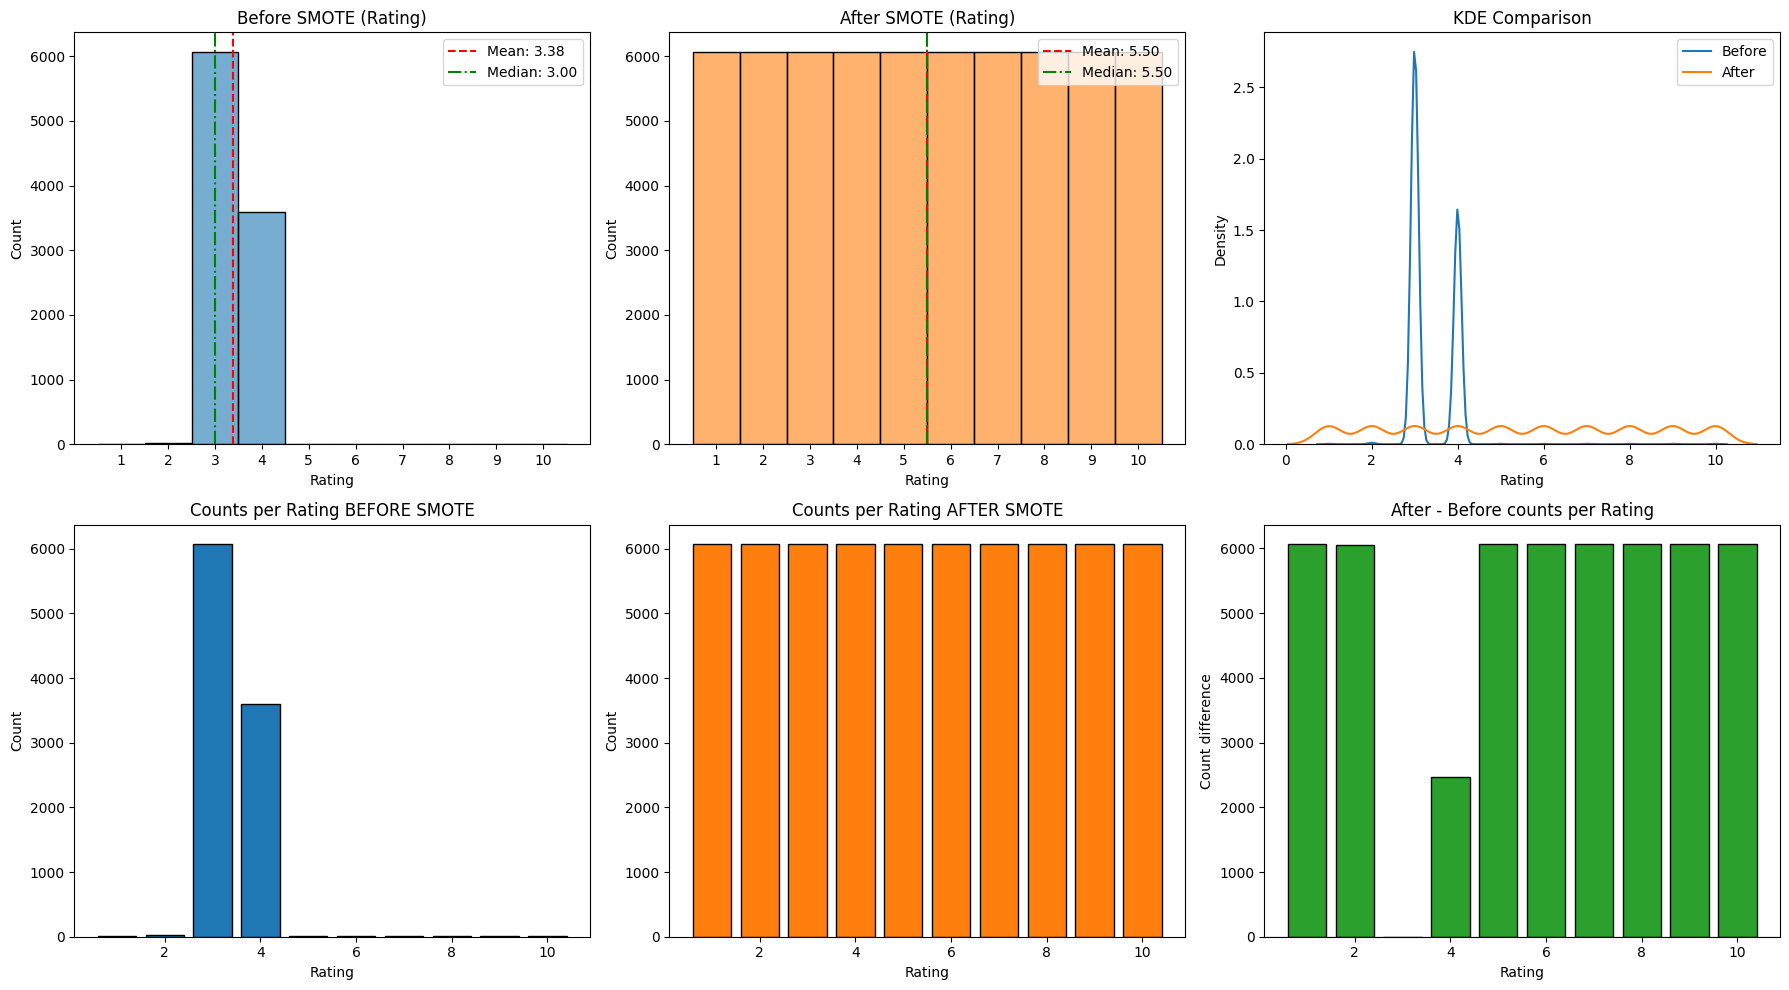

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Use rating_train if available, else fallback to X['Rating']
try:
    rating_before = pd.Series(rating_train).dropna().astype(int)
except NameError:
    rating_before = X['Rating'].dropna().astype(int)

# Use y_train_balanced_rating if available
rating_after = None
if 'y_train_balanced_rating' in globals():
    rating_after = pd.Series(y_train_balanced_rating).dropna().astype(int)

print(f"Samples before SMOTE: {len(rating_before)}")
print(f"Samples after SMOTE: {len(rating_after) if rating_after is not None else 'N/A'}")

# Define bins from 1 to 10
bins_used = np.arange(0.5, 10.5 + 1, 1)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Histogram before SMOTE
sns.histplot(rating_before, bins=bins_used, kde=False, color='C0', ax=axes[0,0], edgecolor='black', alpha=0.6)
axes[0,0].axvline(rating_before.mean(), color='red', linestyle='--', label=f'Mean: {rating_before.mean():.2f}')
axes[0,0].axvline(rating_before.median(), color='green', linestyle='-.', label=f'Median: {rating_before.median():.2f}')
axes[0,0].set_title('Before SMOTE (Rating)')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')
axes[0,0].legend()
axes[0,0].set_xticks(range(1, 11))

# Histogram after SMOTE
if rating_after is not None:
    sns.histplot(rating_after, bins=bins_used, kde=False, color='C1', ax=axes[0,1], edgecolor='black', alpha=0.6)
    axes[0,1].axvline(rating_after.mean(), color='red', linestyle='--', label=f'Mean: {rating_after.mean():.2f}')
    axes[0,1].axvline(rating_after.median(), color='green', linestyle='-.', label=f'Median: {rating_after.median():.2f}')
    axes[0,1].set_title('After SMOTE (Rating)')
    axes[0,1].set_xlabel('Rating')
    axes[0,1].set_ylabel('Count')
    axes[0,1].legend()
    axes[0,1].set_xticks(range(1, 11))
else:
    axes[0,1].text(0.5, 0.5, 'y_train_balanced_rating not available', ha='center', va='center')
    axes[0,1].set_title('After SMOTE (Rating)')

# KDE comparison
sns.kdeplot(rating_before, label='Before', ax=axes[0,2], color='C0')
if rating_after is not None:
    sns.kdeplot(rating_after, label='After', ax=axes[0,2], color='C1')
axes[0,2].set_title('KDE Comparison')
axes[0,2].legend()

# Counts per bin BEFORE
before_counts, _ = np.histogram(rating_before, bins=bins_used)
axes[1,0].bar(range(1, 11), before_counts, color='C0', edgecolor='black')
axes[1,0].set_title('Counts per Rating BEFORE SMOTE')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Count')

# Counts per bin AFTER
if rating_after is not None:
    after_counts, _ = np.histogram(rating_after, bins=bins_used)
    axes[1,1].bar(range(1, 11), after_counts, color='C1', edgecolor='black')
    axes[1,1].set_title('Counts per Rating AFTER SMOTE')
    axes[1,1].set_xlabel('Rating')
    axes[1,1].set_ylabel('Count')
else:
    axes[1,1].text(0.5, 0.5, 'y_train_balanced_rating not available', ha='center', va='center')
    axes[1,1].set_title('Counts per Rating AFTER SMOTE')

# Difference per bin
if rating_after is not None:
    diff = after_counts - before_counts
    axes[1,2].bar(range(1, 11), diff, color='C2', edgecolor='black')
    axes[1,2].axhline(0, color='black', linewidth=0.8)
    axes[1,2].set_title('After - Before counts per Rating')
    axes[1,2].set_xlabel('Rating')
    axes[1,2].set_ylabel('Count difference')
    print('\nCounts per Rating (BEFORE):', before_counts)
    print('Counts per Rating (AFTER):', after_counts)
else:
    axes[1,2].text(0.5, 0.5, 'N/A', ha='center', va='center')
    axes[1,2].set_title('After - Before counts per Rating')

plt.tight_layout()
plt.show()

Linear Regression

✅ Outliers removed: 6110 samples dropped.
✅ Samples outside 0-200 removed: 0
✅ Remaining samples for training: 54570
Price range after cleaning: 3.15 to 63.66

📈 Linear Regression Performance (0-200 price range):
R² Score:  0.058
MAE:       9.75
RMSE:      12.97

🔍 Sample predictions:
   Actual Price  Predicted Price
0         13.95        17.167320
1         27.50        25.101556
2          7.90        18.851813
3         63.49        19.587684
4         16.08        18.697078
5          3.15        16.794431
6          9.49         8.759239
7         11.40        18.371409
8          5.90        19.825558
9         21.50        18.944671

📈 Linear Regression Performance (0-200 price range):
R² Score:  0.058
MAE:       9.75
RMSE:      12.97

🔍 Sample predictions:
   Actual Price  Predicted Price
0         13.95        17.167320
1         27.50        25.101556
2          7.90        18.851813
3         63.49        19.587684
4         16.08        18.697078
5          3.15        16.

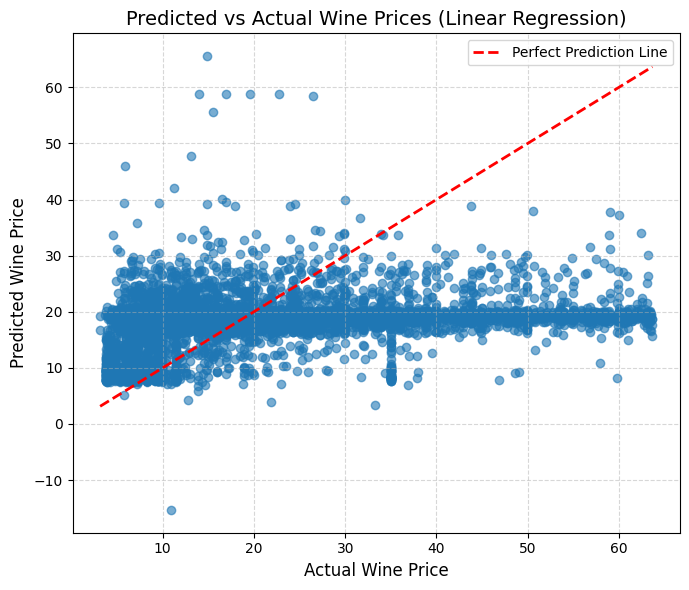

In [74]:
# --- Linear Regression to Predict Wine Price (0-200) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# --- Combine features and target for filtering ---
df_balanced = X_train_balanced.copy()
df_balanced["Price"] = y_train_balanced.values

# --- 1️⃣ Remove outliers using IQR ---
Q1 = df_balanced["Price"].quantile(0.25)
Q3 = df_balanced["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_balanced[
    (df_balanced["Price"] >= lower_bound) & 
    (df_balanced["Price"] <= upper_bound)
].copy()

# --- 2️⃣ Filter prices to 0-200 ---
df_filtered = df_no_outliers[(df_no_outliers["Price"] >= 0) & (df_no_outliers["Price"] <= 200)]

# --- 3️⃣ Extract features and target ---
X_train_cleaned = df_filtered.drop(columns=["Price"])
y_train_cleaned = df_filtered["Price"]

print(f"✅ Outliers removed: {len(df_balanced) - len(df_no_outliers)} samples dropped.")
print(f"✅ Samples outside 0-200 removed: {len(df_no_outliers) - len(df_filtered)}")
print(f"✅ Remaining samples for training: {len(df_filtered)}")
print(f"Price range after cleaning: {y_train_cleaned.min():.2f} to {y_train_cleaned.max():.2f}")

# --- 4️⃣ Split data into train/test sets ---
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_train_cleaned, y_train_cleaned, test_size=0.2, random_state=42
)

# --- 5️⃣ Train Linear Regression model ---
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# --- 6️⃣ Predict on test set ---
y_pred_lr = lr_model.predict(X_test_lr)

# --- 7️⃣ Evaluate performance ---
r2 = r2_score(y_test_lr, y_pred_lr)
mae = mean_absolute_error(y_test_lr, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))

print("\n📈 Linear Regression Performance (0-200 price range):")
print(f"R² Score:  {r2:.3f}")
print(f"MAE:       {mae:.2f}")
print(f"RMSE:      {rmse:.2f}")

# --- 8️⃣ Sample predictions ---
results_df = pd.DataFrame({
    "Actual Price": y_test_lr.values,
    "Predicted Price": y_pred_lr
}).reset_index(drop=True)

print("\n🔍 Sample predictions:")
print(results_df.head(10))

# --- 9️⃣ Plot Predicted vs Actual ---
plt.figure(figsize=(7, 6))
plt.scatter(y_test_lr, y_pred_lr, alpha=0.6)
plt.plot([y_test_lr.min(), y_test_lr.max()],
         [y_test_lr.min(), y_test_lr.max()],
         'r--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Actual Wine Price", fontsize=12)
plt.ylabel("Predicted Wine Price", fontsize=12)
plt.title("Predicted vs Actual Wine Prices (Linear Regression)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


